In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image



from tensorflow.keras.optimizers import Adam 
import time
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization


In [21]:

# Part 1: Training the Model

def plot_graph(history, title, ylabel, filename):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(filename)
    plt.show()


def plot_roc_curve(y_true, y_pred_proba, filename):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.savefig(filename)
    plt.show()

def plot_confusion_matrix(cm, classes, filename):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes)
    plt.yticks(np.arange(len(classes)), classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename)
    plt.show()

def plot_batch_normalization(normalized_values, filename):
    plt.figure()
    for i, values in enumerate(normalized_values):
        plt.plot(values, label=f'Batch {i+1}')
    plt.title('Batch Normalization Values')
    plt.xlabel('Batch')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.savefig(filename)
    plt.show()

def save_to_excel(data, columns, filename):
    df = pd.DataFrame(data, columns=columns)
    df.to_excel(filename, index=False)


def train_model():
    start_time = time.time()

In [23]:
import os
import pandas as pd
from PIL import Image

def get_image_info(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            image_type = img.format
            dimensions = f"{height} × {width}"
            return height, width, dimensions, image_type
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None, None

def generate_excel(directory, output_filename):
    data = {
        "Index": [],
        "Filename": [],
        "Height": [],
        "Width": [],
        "Dimensions": [],
        "Image_Type": [],
        "Class": [],
        "Set": []
    }

    index = 1
    for dataset_type in ["train", "test"]:
        for label in ["benign", "malignant"]:
            folder_path = os.path.join(directory, dataset_type, label)
            for root, _, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    height, width, dimensions, image_type = get_image_info(file_path)
                    if height:
                        data["Index"].append(index)
                        data["Filename"].append(file)
                        data["Height"].append(height)
                        data["Width"].append(width)
                        data["Dimensions"].append(dimensions)
                        data["Image_Type"].append(image_type)
                        data["Class"].append(label)
                        data["Set"].append(dataset_type)
                        index += 1

    df = pd.DataFrame(data)
    df.to_excel(output_filename, index=False)
    print(f"Excel file '{output_filename}' generated successfully!")

# Generate Excel file
generate_excel(".", "Nikitha-221AI026-dataset.xlsx")


Excel file 'Nikitha-221AI026-dataset.xlsx' generated successfully!


In [24]:
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory('train',
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='binary')

test_data = test_datagen.flow_from_directory('test',
                                            target_size=(128, 128),
                                            batch_size=32,
                                            class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 581 images belonging to 2 classes.


In [25]:
    # Display dataset description
    print(f'Training samples: {train_data.samples}, Classes: {train_data.num_classes}')
    print(f'Testing samples: {test_data.samples}, Classes: {test_data.num_classes}')


Training samples: 2637, Classes: 2
Testing samples: 581, Classes: 2


In [26]:
    # Building the Model
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])


In [27]:

    # Displaying layer-wise parameters
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,153 (12.61 MB)

 Trainable params: 3,304,961 (12.61 MB)

 Non-trainable params: 192 (768.00 B)

In [28]:
# Compiling the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 525ms/step - accuracy: 0.8687 - loss: 0.2799 - val_accuracy: 0.8537 - val_loss: 0.3262
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 497ms/step - accuracy: 0.8610 - loss: 0.2772 - val_accuracy: 0.8571 - val_loss: 0.3064
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - accuracy: 0.8688 - loss: 0.2667 - val_accuracy: 0.8589 - val_loss: 0.3158
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 529ms/step - accuracy: 0.8736 - loss: 0.2573 - val_accuracy: 0.8537 - val_loss: 0.2949
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 509ms/step - accuracy: 0.8578 - loss: 0.2772 - val_accuracy: 0.8589 - val_loss: 0.3098
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 526ms/step - accuracy: 0.8855 - loss: 0.2522 - val_accuracy: 0.8657 - val_loss: 0.3080
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 572ms/step - accuracy: 0.8673 - loss: 0.2746 - val_accuracy: 0.8021 - val_loss: 0.4069
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 526ms/step - accuracy: 0.8723 - loss: 0.2672 - val_accu

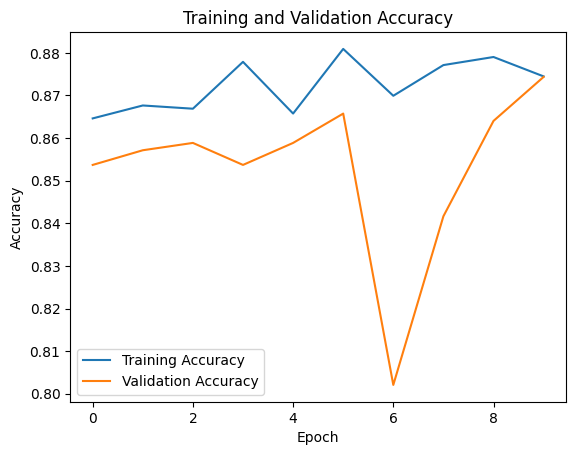

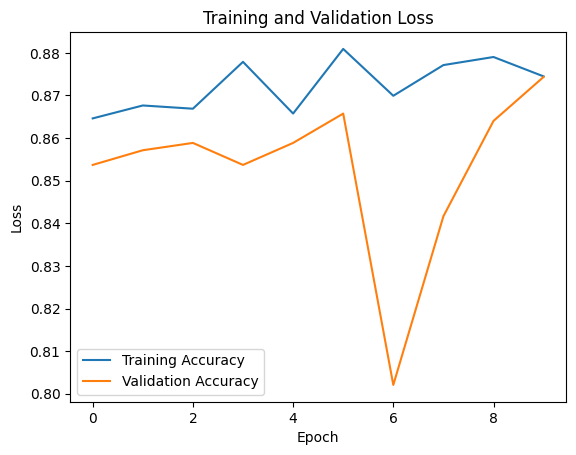

Model saved successfully!


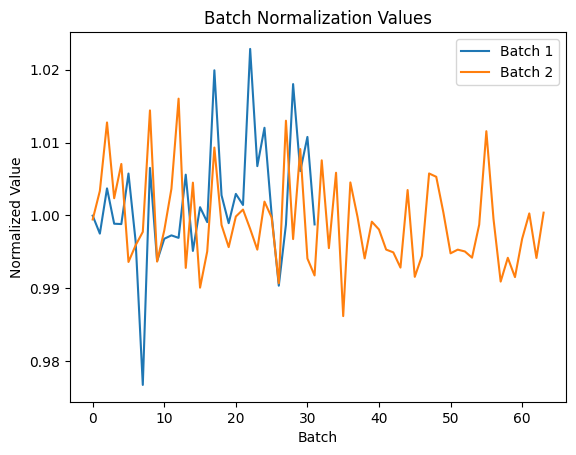

In [33]:
import time

# Record start time
start_time = time.time()


# Training the Model
history = model.fit(train_data, epochs=10, validation_data=test_data)
training_time = time.time() - start_time
print(f'Training Time: {training_time:.2f} seconds')
plot_graph(history, 'Training and Validation Accuracy', 'Accuracy', 'Nikitha-221AI026-accuracygraph.jpeg')
plot_graph(history, 'Training and Validation Loss', 'Loss', 'Nikitha-221AI026-lossgraph.jpeg')

model.save('weights.h5')
print('Model saved successfully!')

save_to_excel([[training_time]], ['Training Time'], 'Nikitha-221AI026-trainingtime.xlsx')

batch_norm_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.BatchNormalization)]
normalized_values = [layer.get_weights()[0] for layer in batch_norm_layers]  # Get BatchNorm gamma values
plot_batch_normalization(normalized_values, 'Nikitha-221AI026-batchnorm.jpeg')





In [48]:
train_model()


Found 581 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual: 0.0, Predicted: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Actual: 0.0, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Actual: 0.0, Predicted: 0

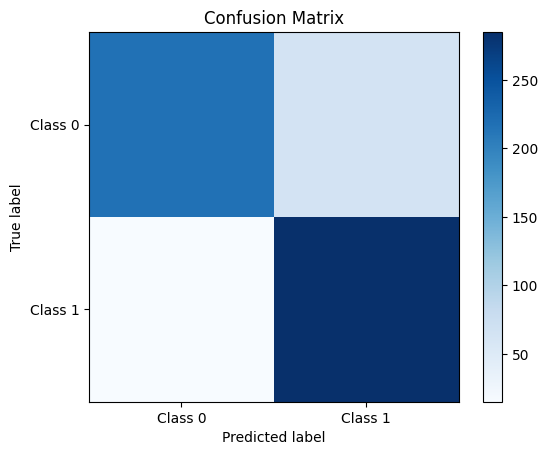

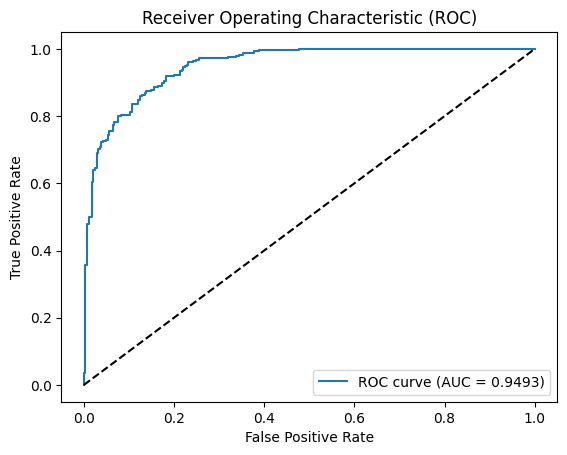

Accuracy: 0.8640, Precision: 0.8166, Recall: 0.9500, F1: 0.8783, MCC: 0.7370
Total Misclassifications: 79
Evaluation Completed!


In [ ]:
# Part 2: Testing and Evaluation 
from tensorflow.keras.models import load_model

def evaluate_model():
    model = load_model('weights.h5')
    test_data = ImageDataGenerator(rescale=1.0/255).flow_from_directory('test', target_size=(128, 128), batch_size=1, class_mode='binary', shuffle=False)

    y_true, y_pred, y_pred_proba = [], [], []
    total_time, misclassifications = 0, 0

    for i in range(len(test_data)):
        start = time.time()
        img, label = test_data[i]
        prediction = model.predict(img)
        elapsed = time.time() - start
        total_time += elapsed

        predicted_label = 1 if prediction > 0.5 else 0
        y_true.append(int(label[0]))
        y_pred.append(predicted_label)
        y_pred_proba.append(prediction[0][0])

        if predicted_label != int(label[0]):
            misclassifications += 1
        print(f'Actual: {label[0]}, Predicted: {predicted_label}')

    avg_time_per_input = total_time / len(test_data)
    print(f'Average Testing Time per Input: {avg_time_per_input:.6f} seconds')

    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, ['Class 0', 'Class 1'], 'Nikitha-221AI026-confusionmatrix.jpeg')
    plot_roc_curve(y_true, y_pred_proba, 'Nikitha-221AI026-roc.jpeg')

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}')
    print(f'Total Misclassifications: {misclassifications}')

    save_to_excel([[accuracy, precision, recall, f1, mcc, avg_time_per_input, misclassifications]], ['Accuracy', 'Precision', 'Recall', 'F1', 'MCC', 'Avg Time', 'Misclassifications'], 'Nikitha-221AI026-results.xlsx')
    save_to_excel(zip(y_true, y_pred), ['Actual', 'Predicted'], 'Nikitha-221AI026-prediction.xlsx')
    print('Evaluation Completed!')

evaluate_model()



In [54]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model('weights.h5')

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img = image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_image(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)

    # Get the prediction value
    pred_value = prediction[0][0]
    label = 'benign' if pred_value > 0.5 else 'malignant'
    print(f'The image "{image_path}" is classified as {label} with a probability of {pred_value:.4f}.')
    return label

# Test the prediction
image_path = 'test/malignant/1.jpg'
result = predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
The image "test/malignant/1.jpg" is classified as benign with a probability of 0.9825.
